In [33]:
# imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases, TfidfModel, CoherenceModel
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy
import en_core_web_sm
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
#nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nltk.download('wordnet')
stop_words = stopwords.words('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Functions

## Data Loading

In [3]:
def load_data(folder_path):
    data = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            file_path = folder_path + '/' + filename
            
            with open(file_path, 'r') as f:
                text = f.read()
            f.closed
            
            text = text.strip().replace('\n', '')
            sentences = re.findall(r'<sentence .*?>(.*?)</sentence>+', text)
            name = re.findall(r'<name>(.*?)</name>+', text)[0]

            # ako bude trebao name vrati ovo
            # U TOM SLUCAJU procitaj komentar ispod
            # documents je lista dokumenata, gde je svaki dokument lista od dva elementa: prvi je naslov, a drugi lista recenica!
            #data.append([name, sentences])
            
            data.append(sentences)
            
    return data

In [4]:
# pretvara listu recenica svakog od dokumenata u plaintext
def create_plaintext_from_sentences(documents):
    data = []
    
    for document in documents:
        data.append(' '.join(document))
        
    return data

## Preprocessing

In [5]:
# tokenization and stopwords removing 
def preprocess(text):
    result = []
    #stemmer = PorterStemmer()
    #lemmatizer = WordNetLemmatizer()
    
    for token in simple_preprocess(text):                       # deacc=True za uklanjanje znakova interpunkcije
        if token not in stop_words and len(token) > 3:
            result.append(token)
            
    return result

In [7]:
def lemmatization(documents, allowed_pos_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    documents_out = []
    
    for document in documents:
        if(len(document) > 100000 or len(document) < 10):   # da ne obradjuje prevelike dokumente, ima problema sa memorijom, a i svakako mi ne trebaju
            print(len(document))
        else:
            doc = nlp(' '.join(document))
            documents_out.append([token.lemma_ for token in doc if token.pos_ in allowed_pos_tags])
        
    return documents_out

## Phrase modeling using ngrams

In [8]:
def create_ngram_models(documents):
    bigram = Phrases(documents, min_count=5, threshold=100)
    trigram = Phrases(bigram[documents], threshold=100)
    
    bigram_model = Phraser(bigram)
    trigram_model = Phraser(trigram)
    
    return bigram_model, trigram_model

In [9]:
def make_bigrams(documents, bigram_model):
    return [bigram_model[document] for document in documents]

def make_trigrams(documents, trigram_model):
    return [trigram_model[document] for document in documents]

## Dictionary and corpus for LDA

In [10]:
def create_dictionary(documents):
    return Dictionary(documents)

def create_corpus(documents, dictionary):
    return [dictionary.doc2bow(document) for document in documents]

## Build LDA topic model

In [11]:
def build_lda_model(dictionary, corpus, lda_params, use_mallet=True):
    num_topics, alpha, beta = lda_params
    
    if(use_mallet):
        mallet_path = 'C:/mallet/mallet-2.0.8/bin/mallet.bat'
        lda_model = LdaMallet(mallet_path,
                              corpus=corpus,
                              id2word=dictionary,
                              num_topics=num_topics,
                              alpha=alpha)
    else:
        lda_model = LdaModel(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics,
                             random_state=33,
                             update_every=1,
                             chunksize=100,
                             passes=10,
                             alpha=alpha,
                             eta=beta,
                             per_word_topics=True)
    
    return lda_model

## Evaluation using coherence score

In [12]:
# Coherence
def get_coherence_score_lda(lda_model, dictionary, texts):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

## Find optimal number of topics for LDA

In [47]:
def find_best_number_of_topics(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    i = 0
    
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=33,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         eta=0.001,
                         per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        i += 1
        print('Done ' + str(i))
        
    return model_list, coherence_values

def plot_coherence_scores(coherence_values, limit, start=2, step=3):
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')

## Topics - keywords visualization

In [39]:
def topics_visualization(lda_model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    return vis

# Apply functions on Legal Case Reports Dataset

### Data loading

In [15]:
documents = load_data('corpus/fulltext')
print('\n'.join(documents[0])) 

 Background to the current application  1 The applicants Sharman Networks Ltd ('Sharman Networks'), Sharman License Holdings Ltd ('Sharman License') and Ms Nicola Anne Hemming ('Ms Hemming') are each the subject of asset preservation orders made by Wilcox J on 22 March 2005 ('the Mareva orders').
When referring to the applicants generally, I will do so as 'the Sharman applicants'.
Each of the Sharman applicants was one of ten respondents to infringement of copyright proceedings brought by the present respondents ('the Music companies') in respect of the operation of what was described by the parties as the 'Kazaa system' ('the primary proceedings').
Wilcox J made orders ancillary to the Mareva orders on 22 March 2005 requiring each of the Sharman applicants to disclose on affidavit the description and value of all of their assets, wherever situated, and to specify whether those assets were held by each applicant either beneficially or in trust for any other person or entity.
2 Wilcox J

Associate:Dated: 5 January 2006 Counsel for the First, Second and Third Applicants: J M Ireland QC   Solicitor for the First, Second and Third Applicants: Clayton Utz   Counsel for the First to Thirtieth Respondents: R Cobden SC and J M Hennessy   Solicitor for the First to Thirtieth Respondents: Gilbert + Tobin   Date of Hearing: 30 November and 1 December 2005   Date of Judgment: 5 January 2006    AustLII: Copyright Policy | Disclaimers | Privacy Policy | Feedback  URL: http://www.austlii.edu.au/au/cases/cth/FCA/2006/1.html   


In [16]:
# transform lists of sentences into plaintext
documents = create_plaintext_from_sentences(documents)
print(documents[0])

 Background to the current application  1 The applicants Sharman Networks Ltd ('Sharman Networks'), Sharman License Holdings Ltd ('Sharman License') and Ms Nicola Anne Hemming ('Ms Hemming') are each the subject of asset preservation orders made by Wilcox J on 22 March 2005 ('the Mareva orders'). When referring to the applicants generally, I will do so as 'the Sharman applicants'. Each of the Sharman applicants was one of ten respondents to infringement of copyright proceedings brought by the present respondents ('the Music companies') in respect of the operation of what was described by the parties as the 'Kazaa system' ('the primary proceedings'). Wilcox J made orders ancillary to the Mareva orders on 22 March 2005 requiring each of the Sharman applicants to disclose on affidavit the description and value of all of their assets, wherever situated, and to specify whether those assets were held by each applicant either beneficially or in trust for any other person or entity. 2 Wilcox J

### Preprocessing

In [17]:
# it might take a while
preprocessed_docs = []
for document in documents:
    preprocessed_docs.append(preprocess(document))

In [18]:
print(' '.join(preprocessed_docs[0]))

background current application applicants sharman networks sharman networks sharman license holdings sharman license nicola anne hemming hemming subject asset preservation orders made wilcox march mareva orders referring applicants generally sharman applicants sharman applicants respondents infringement copyright proceedings brought present respondents music companies respect operation described parties kazaa system primary proceedings wilcox made orders ancillary mareva orders march requiring sharman applicants disclose affidavit description value assets wherever situated specify whether assets held applicant either beneficially trust person entity wilcox delivered judgment complex issues liability arising primary proceedings september universal music australia sharman license holdings meantime hemming filed disclosure affidavits pursuant wilcox orders march whilst sharman license sharman networks unsuccessfully sought several stays various grounds order insofar applied universal musi

### Create bigrams and trigrams

In [19]:
# trigram model isn't used for now
bigram_model, trigram_model = create_ngram_models(preprocessed_docs)
print(trigram_model[bigram_model[preprocessed_docs[0]]])

['background', 'current', 'application', 'applicants', 'sharman_networks', 'sharman_networks', 'sharman_license_holdings', 'sharman_license', 'nicola', 'anne', 'hemming', 'hemming', 'subject', 'asset_preservation_orders', 'made', 'wilcox', 'march', 'mareva', 'orders', 'referring', 'applicants', 'generally', 'sharman', 'applicants', 'sharman', 'applicants', 'respondents', 'infringement_copyright', 'proceedings', 'brought', 'present', 'respondents', 'music_companies', 'respect', 'operation', 'described', 'parties', 'kazaa', 'system', 'primary', 'proceedings', 'wilcox', 'made', 'orders', 'ancillary', 'mareva', 'orders', 'march', 'requiring', 'sharman', 'applicants', 'disclose', 'affidavit', 'description', 'value', 'assets', 'wherever_situated', 'specify', 'whether', 'assets', 'held', 'applicant', 'either', 'beneficially', 'trust', 'person', 'entity', 'wilcox', 'delivered', 'judgment', 'complex', 'issues', 'liability', 'arising', 'primary', 'proceedings', 'september', 'universal_music', 'a

In [20]:
bigrams = make_bigrams(preprocessed_docs, bigram_model)
trigrams = make_trigrams(preprocessed_docs, trigram_model)

### Bigrams lemmatization

In [21]:
# it might take a while
data_lemmatized = lemmatization(bigrams, allowed_pos_tags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts = data_lemmatized

184190


### Create dictionary and corpus

In [23]:
dictionary = create_dictionary(data_lemmatized)
corpus = create_corpus(data_lemmatized, dictionary)

### Build LDA model

In [24]:
params_lda = (20, 0.1, 0.001)    # num_topics, alpha, eta
lda_model = build_lda_model(dictionary, corpus, params_lda, use_mallet=False)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"court" + 0.041*"order" + 0.026*"proceeding" + 0.024*"cost" + '
  '0.022*"make" + 0.022*"application" + 0.014*"party" + 0.013*"seek" + '
  '0.012*"case" + 0.011*"judgment"'),
 (1,
  '0.055*"document" + 0.031*"information" + 0.015*"make" + 0.013*"letter" + '
  '0.012*"provide" + 0.012*"file" + 0.011*"evidence" + 0.010*"email" + '
  '0.010*"client" + 0.010*"report"'),
 (2,
  '0.030*"work" + 0.027*"employee" + 0.025*"conduct" + 0.019*"site" + '
  '0.017*"contravention" + 0.014*"penalty" + 0.011*"union" + 0.010*"action" + '
  '0.009*"respondent" + 0.009*"make"'),
 (3,
  '0.056*"claim" + 0.048*"patent" + 0.021*"invention" + 0.020*"application" + '
  '0.017*"specification" + 0.012*"say" + 0.010*"product" + 0.010*"would" + '
  '0.009*"gray" + 0.009*"use"'),
 (4,
  '0.042*"claim" + 0.020*"lease" + 0.019*"contract" + 0.015*"property" + '
  '0.015*"offer" + 0.013*"term" + 0.012*"settlement" + 0.012*"rent" + '
  '0.011*"would" + 0.011*"damage"'),
 (5,
  '0.036*"evidence" + 0.029*"sa

### Evaluation

In [25]:
# compute perplexity
# ne radi za LdaMallet
print('\nPerplexity: ', lda_model.log_perplexity(corpus))       # sto nize to bolje

# compute coherence score
coherence_lda = get_coherence_score_lda(lda_model, dictionary, texts)
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -63.27952935821984

Coherence Score:  0.44499965612767955


### Visualization

In [40]:
# this will take a while
vis = topics_visualization(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.052761 -0.073742       1        1  11.759427
0     -0.127768  0.069660       2        1  11.121251
16    -0.064829 -0.027460       3        1   8.407876
9     -0.190776  0.013193       4        1   8.204730
11    -0.153714  0.062469       5        1   5.530453
1     -0.051553  0.008038       6        1   5.047452
14     0.204167  0.090083       7        1   4.829120
18    -0.099752  0.003446       8        1   4.152709
2     -0.009472  0.015987       9        1   4.111753
15    -0.037250 -0.107370      10        1   3.930521
6     -0.139313  0.057744      11        1   3.862514
7      0.125362  0.095362      12        1   3.831634
12     0.134138 -0.083094      13        1   3.716018
17     0.076434 -0.116397      14        1   3.715740
10    -0.023681 -0.038302      15        1   3.630075
19     0.065773  0.180188      16        1   3.448753
4      0.128432  0.099869      17        1   3.412284
13     0.082719  0.122885      18        1   2.974059
8      0.111838 -0.195390      19        1   2.559608
3      0.022007 -0.177167      20        1   1.754024, topic_info=     Category          Freq          Term         Total  loglift  logprob
51    Default  90947.000000     applicant  90947.000000  30.0000  30.0000
776   Default  60744.000000    respondent  60744.000000  29.0000  29.0000
142   Default  67890.000000         claim  67890.000000  28.0000  28.0000
3010  Default  38964.000000      tribunal  38964.000000  27.0000  27.0000
28    Default  32688.000000     agreement  32688.000000  26.0000  26.0000
...       ...           ...           ...           ...      ...      ...
1069  Topic20    737.845398          base  10476.025391   1.3901  -5.2910
1689  Topic20    693.572876  construction   7881.593262   1.6128  -5.3529
736   Topic20    722.093628     reference  12201.969727   1.2161  -5.3126
35    Topic20    769.756592          also  41042.207031   0.0670  -5.2486
751   Topic20    722.471924      relevant  28246.621094   0.3772  -5.3120

[1609 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1430     12  0.988421       abate
3099     15  1.000000  aboriginal
1032      5  1.005670     abridge
5562      2  1.001756     abscond
4633      9  1.000439        accc
...     ...       ...         ...
957      15  0.021143        year
957      17  0.032588        year
957      19  0.001810        year
957      20  0.001616        year
6366     18  1.057611       zohar

[6172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 17, 10, 12, 2, 15, 19, 3, 16, 7, 8, 13, 18, 11, 20, 5, 14, 9, 4])

### Find optimal number of topics

In [49]:
model_list, coherence_values = find_best_number_of_topics(dictionary=dictionary, corpus=corpus, texts=texts, limit=40, start=2, step=3)

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
Done 12
Done 13


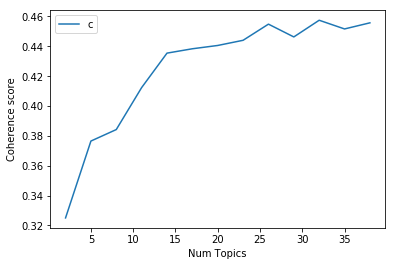

In [51]:
plot_coherence_scores(coherence_values, limit=40, start=2, step=3)